In [1]:
import os                                                   # to set current working directory 
import numpy as np                                          # arrays and matrix math
import scipy.stats as st                                    # statistical methods
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # for plotting
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.metrics import explained_variance_score
import seaborn as sns                                       # advanced plotting
import sys                                                  # interactive with terminal window to install pymc3 package
seed = 73073

In [2]:
import pymc as pm
import arviz

print('pymc3 version is ' + str(pm.__version__))
print('arviz version is ' + str(arviz.__version__))

pymc3 version is 5.6.1
arviz version is 0.16.1


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/GrainSize_Por.csv")
df.head()

,Grainsize,Porosity
0,2.689284,5.400000
1,6.683638,10.647582
2,9.877106,7.926271
3,12.239344,11.278953
4,27.623312,10.508753


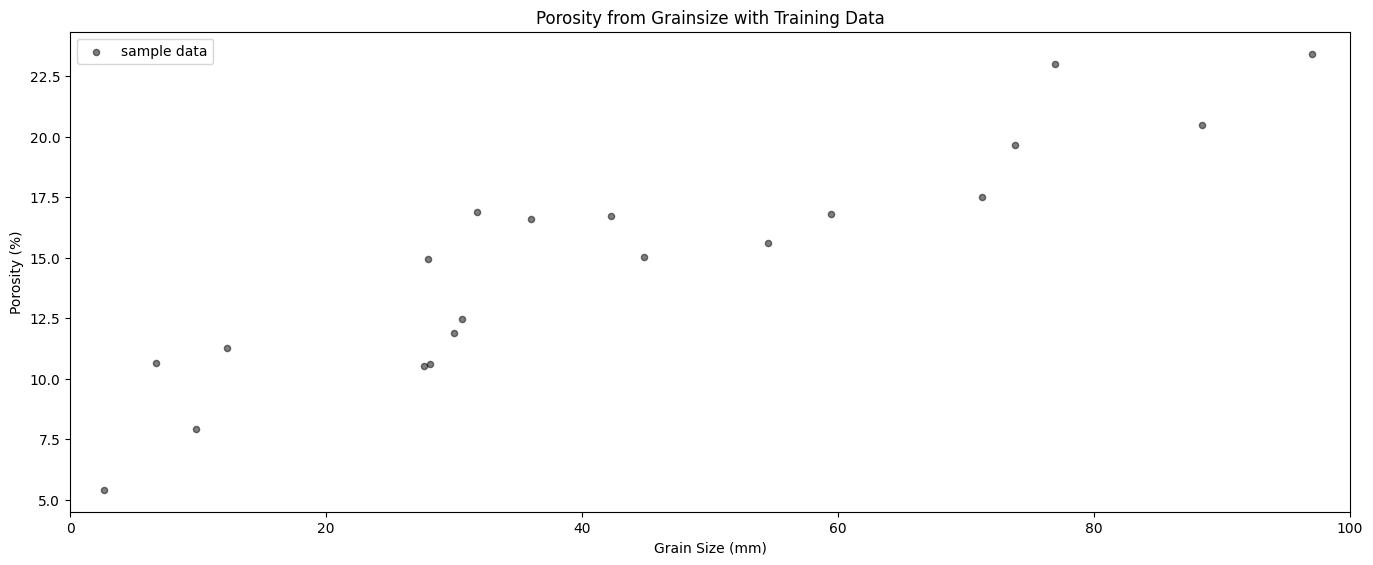

In [4]:
X_data = df.iloc[:,0]
y_data = df.iloc[:,1]
plt.subplot(111)
plt.scatter(X_data, y_data, color='black', s = 20, alpha = 0.5, label='sample data')
plt.title('Porosity from Grainsize with Training Data'); plt.xlabel('Grain Size (mm)'); plt.ylabel('Porosity (%)')
plt.xlim(0,100)#; plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

In [9]:
OLS_slope, OLS_intercept, r_value, p_value, std_err = st.linregress(X_data,y_data)

print('The model parameters are, slope (b1) = ' + str(round(OLS_slope,2)) + ', and the intercept (b0) = ' + str(round(OLS_intercept,2)))

The model parameters are, slope (b1) = 0.16, and the intercept (b0) = 8.12


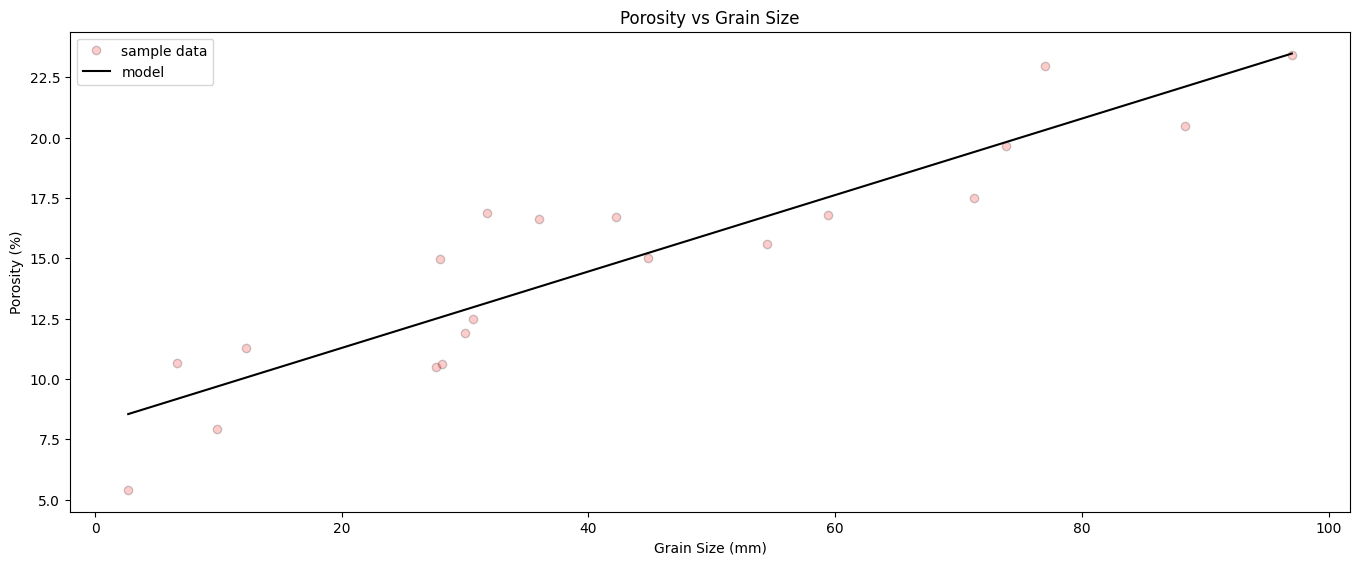

In [10]:
plt.subplot(111)
plt.plot(X_data, y_data, 'o', label='sample data', color = 'red', alpha = 0.2, markeredgecolor = 'black')
plt.plot(X_data, OLS_intercept + OLS_slope*X_data, label='model', color = 'black')
plt.title('Porosity vs Grain Size')
plt.xlabel('Grain Size (mm)')
plt.ylabel('Porosity (%)')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

In [27]:
t_crit = st.t.ppf([0.025, 0.975], df=len(X_data)-2)
print(std_err)
print(OLS_slope+std_err*t_crit)

0.016643596086172364
[0.12345883 0.19339263]


In [81]:
with pm.Model() as linear_all_data:
    # prior distributions, Naive - set to Gaussian with very large variance
    intercept = pm.Normal('Intercept', mu = 0, sigma = 10.0) # model B0 - Intercept Prior
    slope = pm.Normal('slope', mu = 0, sigma = 10.0)         # model B1 - Slope Prior 
    sigma = pm.HalfNormal('sigma', sigma = 10.0)             # homoscedastic error in standard deviation
    
    # specify the model, linear regression
    mean = intercept + slope * X_data                     # estimate of model
    
    # define the distribution of the predictions from the model and provide the sampled response features
    Y_obs = pm.Normal('Y_obs', mu = mean, sigma = sigma, observed = y_data.values[:]) # Observed values
    
    # specify the sampler
    step = pm.Metropolis(vars=[intercept, slope, sigma]) # use the No-U-Turn Sampler (NUTS) for Markov Chains Monte Carlo MCMC, addaptive step size

    # Posterior distribution
    #linear_trace_all_data = pm.sample(draws = 500, tune = 500, step = step, random_seed = seed, return_inferencedata = True)
    # linear_trace_all_data = pm.sample(draws = 500, tune = 500, step = step, random_seed = seed, 
    #                                   discard_tuned_samples = False,return_inferencedata=True)
    linear_trace_all_data = pm.sample(draws=4, tune=100, step=step, discard_tuned_samples=False)

Only 4 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Intercept]
>Metropolis: [slope]
>Metropolis: [sigma]


Sampling 4 chains for 100 tune and 4 draw iterations (400 + 16 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.


In [82]:
linear_trace_all_data.warmup_posterior
test = linear_trace_all_data.warmup_posterior
test

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 100)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    Intercept  (chain, draw) float64 0.0 0.9307 0.1729 ... 9.946 10.17 10.17
    slope      (chain, draw) float64 0.0 0.0 0.0 0.0 ... 0.1138 0.1138 0.1138
    sigma      (chain, draw) float64 10.0 17.53 17.53 ... 1.834 2.508 2.508
Attributes:
    created_at:                 2023-07-29T20:07:21.101729
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.6.1
    sampling_time:              0.18653440475463867
    tuning_steps:               100

In [84]:
test2 = linear_trace_all_data.warmup_sample_stats
test2

<xarray.Dataset>
Dimensions:         (chain: 4, draw: 100, scaling_dim_0: 3, accepted_dim_0: 3,
                     accept_dim_0: 3)
Coordinates:
  * chain           (chain) int64 0 1 2 3
  * draw            (draw) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * scaling_dim_0   (scaling_dim_0) int64 0 1 2
  * accepted_dim_0  (accepted_dim_0) int64 0 1 2
  * accept_dim_0    (accept_dim_0) int64 0 1 2
Data variables:
    scaling         (chain, draw, scaling_dim_0) float64 1.0 1.0 1.0 ... 1.0 1.0
    accepted        (chain, draw, accepted_dim_0) float64 0.0 0.0 ... 0.0 0.0
    accept          (chain, draw, accept_dim_0) float64 0.0247 ... 0.1358
Attributes:
    created_at:                 2023-07-29T20:07:21.111790
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.6.1
    sampling_time:              0.18653440475463867
    tuning_steps:               100

In [11]:
def trace_mean(x):
    return pd.Series(np.average(x, 0), name='mean')

def trace_sd(x):
    return pd.Series(np.std(x, 0), name='sd')

def trace_975(x):
    return pd.Series(np.percentile(x, 97.5), name='97.5')

def trace_025(x):
    return pd.Series(np.percentile(x, 2.5), name='2.5')

# Get the expectation / average for the model parameters from sampling the posterior distribution
bayes_exp_intercept = pm.stats.summary(linear_trace_all_data, stat_funcs = [trace_mean]).iloc[0,0]
bayes_exp_slope = pm.stats.summary(linear_trace_all_data, stat_funcs = [trace_mean]).iloc[1,0]

pm.stats.summary(linear_trace_all_data, stat_funcs = [trace_mean, trace_sd, trace_025, trace_975])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,trace_mean,trace_sd,trace_025,trace_975
Intercept,8.011,0.887,6.511,9.820,0.118,0.086,57.0,218.0,1.09,8.011,0.887,6.127,9.698
slope,0.160,0.018,0.133,0.200,0.003,0.002,33.0,131.0,1.11,0.160,0.018,0.126,0.200
sigma,2.145,0.376,1.466,2.864,0.015,0.011,616.0,641.0,1.01,2.145,0.376,1.539,3.070


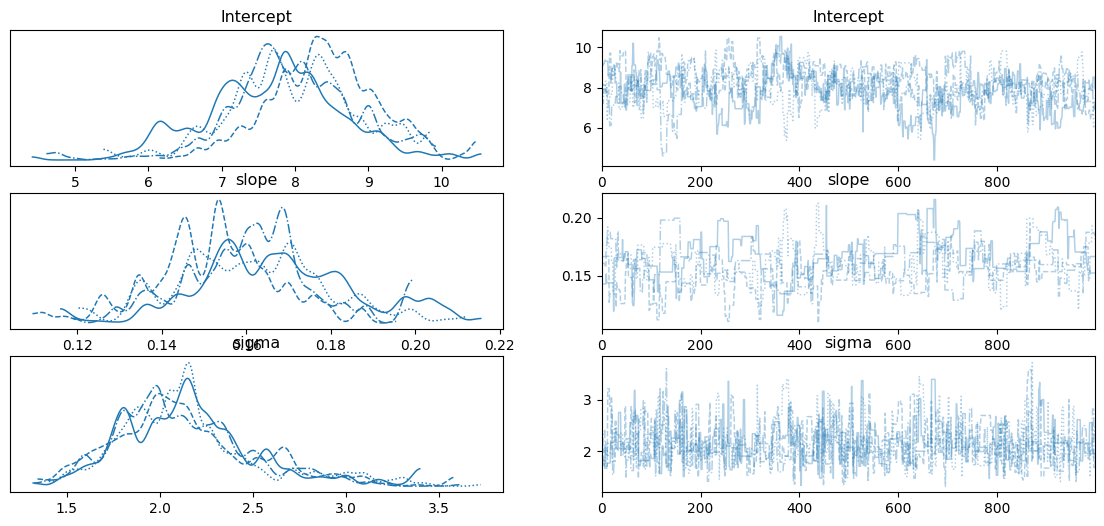

In [12]:
with linear_all_data:
    pm.plot_trace(linear_trace_all_data, figsize = (14,6))

#plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

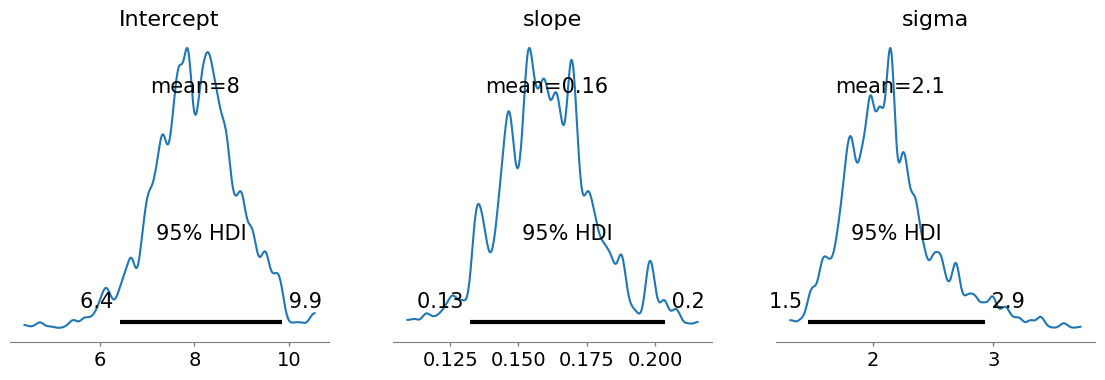

In [13]:
with linear_all_data:
    pm.plot_posterior(linear_trace_all_data,hdi_prob = 0.95, figsize = (14,4))
plt.show()

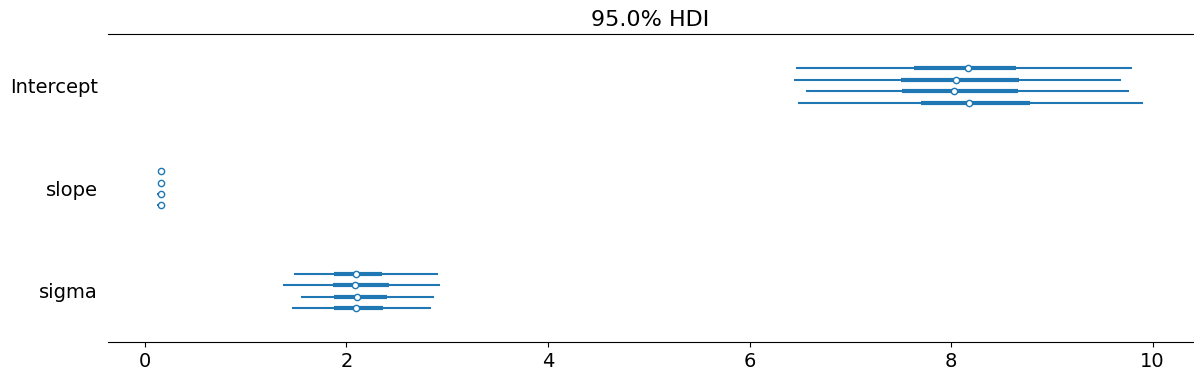

In [33]:
with linear_all_data:
    pm.plot_forest(linear_trace_all_data, hdi_prob = 0.95, figsize = (14,4))
plt.show()

AttributeError: Line2D.set() got an unexpected keyword argument 'eval'

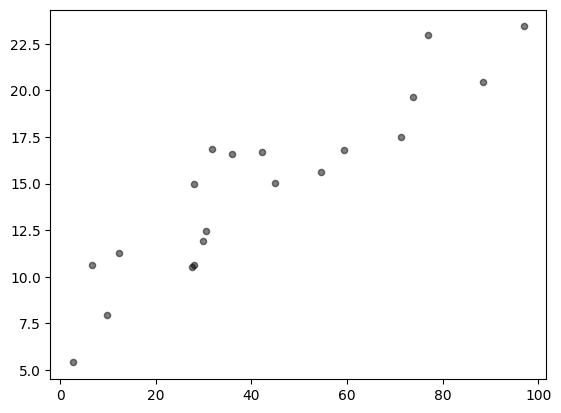

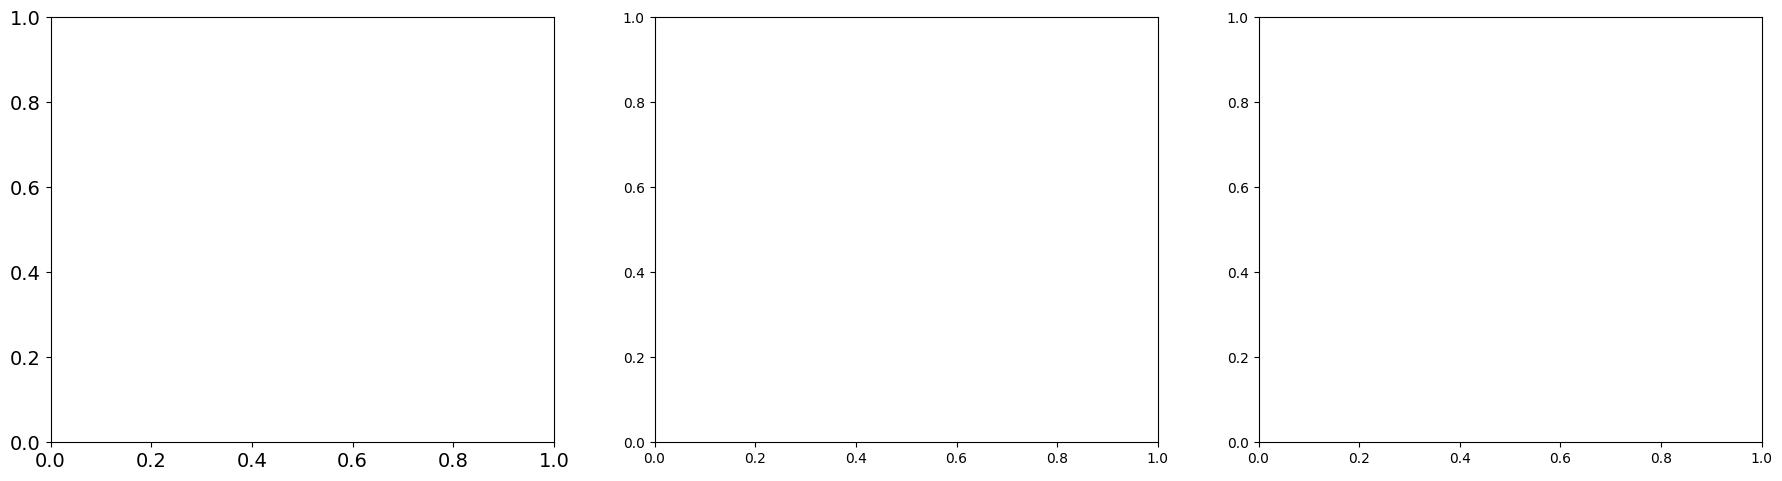

In [36]:
plt.subplot(111)
plt.scatter(X_data, y_data, color='black', s = 20, alpha = 0.5, label='sample data', zorder = 3)
arviz.plot_posterior(linear_trace_all_data, samples = 1000, eval=np.linspace(2, 100, 100), linewidth = 1, color = 'red', alpha = 0.02, label = 'Bayesian Posterior Models',lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x, zorder = 1)
plt.plot(X_data, bayes_exp_intercept + bayes_exp_slope*X_data, label='OLS Model', color = 'black', zorder= 2)
plt.title('Porosity from Grainsize Bayesian Model'); plt.xlabel('Grain Size (mm)'); plt.ylabel('Porosity (%)')
plt.xlim(0,100)#; plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()